In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import random as python_random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import itertools
import tensorflow_probability as tfp

from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Input, Dense,Concatenate, Reshape, Activation, BatchNormalization,Flatten, Embedding, Dot, Dropout

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
### I wrote the code in a hacky way to make debugging easier. That is, this hacky code allows you to treat an abstract weight matrix as a class variable like a keras symbolic tensor.    
class DoGenVec(tf.keras.layers.Layer):

    def __init__(self, Info):
        super(DoGenVec, self).__init__()
        self.NumCl = Info[0]
        self.EmbedDim = Info[1]

    def get_config(self):

        config = super().get_config().copy()
        config.update({'EmbedDim': self.EmbedDim , 'NumCl': self.NumCl })
        return config

    def build(self, input_shape):
        np.random.seed(1)
        self.GenVec = tf.Variable(np.random.normal(0, 0.1, size=(self.NumCl, self.EmbedDim)).astype(np.float32), trainable=True, name='GenVec')

    def call(self, input):
        input = K.sum(input) * 0 + 1 # To return only the weight matrix, make the previous input tensor value a scalar 1 and multiply it with the weight matrix. It's just a hacky trick
        return (input*self.GenVec)


### I wrote the code in a hacky way to make debugging easier. That is, this hacky code allows you to treat an abstract weight matrix as a class variable like a keras symbolic tensor.    
class SuppleVec(tf.keras.layers.Layer):

    def __init__(self, Info):
        super(SuppleVec, self).__init__()

    def build(self, input_shape):
        self.GenVec1 = tf.constant(ExogDTL, name='gen1')
        self.GenVec2 = tf.constant(ExogPRM, name='gen2')
        self.GenVec3 = tf.constant(np.arange(len(ExpData.columns)) + 1)

    def call(self, input):
        return (self.GenVec1, self.GenVec2, self.GenVec3 )    
    
    
def soft_rank(x, tau=1.0):
    x_exp = tf.expand_dims(x, -1)
    x_exp_t = tf.expand_dims(x, -2)
    pairwise_diff = x_exp - x_exp_t
    pairwise_rank = tf.math.sigmoid(-pairwise_diff / tau)
    rank = tf.reduce_sum(pairwise_rank, axis=-1)
    return rank

In [3]:
TotalData = pd.read_csv('../../1.Data/ProcessedData/TotalData.csv')
IntToGene = np.load('../../1.Data/ProcessedData/IntToGene_GroupNorm.npy', allow_pickle=True).tolist()
IntToPat = np.load('../../1.Data/ProcessedData/IntToPat_GroupNorm.npy', allow_pickle=True).tolist()
DistMat = np.load('../../1.Data/ProcessedData/DisimInd_GroupNorm.npy', allow_pickle=True)
TTE = np.load('../../1.Data/ProcessedData/TTE_GroupNorm.npy', allow_pickle=True)
EVENT = np.load('../../1.Data/ProcessedData/Event_GroupNorm.npy', allow_pickle=True)

ExpData = TotalData.drop(columns=['patient_id','tumor_type','time','event']).T
ExpData.columns = ExpData.columns +1
ExpData = ExpData.set_index(np.arange(len(ExpData))+1)

In [4]:
# Masking vectors used for learning risk ordered embedding vectors
NegativeMask = ((TTE[:,None] - TTE[None])<0).astype('int')
NegativeNonEvent = NegativeMask * (1-EVENT[None])
PositiveMask = ((TTE[:,None] - TTE[None])>0).astype('int')
PositiveEvent = PositiveMask * EVENT[None]
TrIndEmbeddMask = (NegativeNonEvent + PositiveEvent).astype('float32')

# Setting the reference ID (Longest survivor vs shortest death)
ReferencePatIDLong = np.argmax(TTE * (EVENT==0).astype('float32'))
ReferencePatIDShort = np.where( (TTE == np.min(TTE [EVENT.astype('bool')]) ) & (EVENT==1))[0][0]

# Data processing for deep learning model training
NormDismInd = ((DistMat - DistMat.min()) / (DistMat.max() - DistMat.min())) 
NormDismInd = tf.constant(NormDismInd, dtype=tf.float32)
TrIndEmbeddMask = tf.constant(TrIndEmbeddMask, dtype=tf.float32)

ExogDTL = NormDismInd
ExogPRM = TrIndEmbeddMask
LOCPEM_lr = ReferencePatIDLong

In [49]:
EmbedSize = 50
NCL_Feat = 5
NCL_Ind = 2
IndN = len(ExpData.columns)
FeatN = len(ExpData)
window_size = 3
SR_Tau = 0.005

XI1 = 0.001 #ξ_1
XI2 = 1. #ξ_2


InpFeat = Input(shape=(1,))
DTL, PRM , IndIdx = SuppleVec([])(InpFeat)
BatchInpIdx = tf.cast(InpFeat, dtype=tf.int32)

GEM = tf.transpose(DoGenVec([EmbedSize, FeatN + 1])(InpFeat))
GEMNorm = tf.linalg.l2_normalize(GEM[:], axis=-1)
PEM = tf.transpose(DoGenVec([EmbedSize, IndN + 1 ])(InpFeat))
PEMNorm = tf.linalg.l2_normalize(PEM[1:], axis=-1)
PCM = DoGenVec([NCL_Ind, EmbedSize ])(InpFeat)
GCM = DoGenVec([1, NCL_Feat ])(InpFeat)
GCM = tf.nn.softplus(GCM)
PCMNorm = tf.linalg.l2_normalize(PCM, axis=-1)

GEMBatch = tf.nn.embedding_lookup(GEM[:], tf.cast(InpFeat, dtype=tf.int32))[:,0]
GEMBatchNorm = tf.linalg.l2_normalize(GEMBatch, axis=-1) 

Out = tf.matmul(GEMBatch,PEM[1:], transpose_b=True )
Out = Reshape((-1,), name='OutVal')(Out) 

## Patient clustering
# CHLoss_pat 
ICosCLSim = tf.matmul( PEMNorm, PCMNorm, transpose_b=True)
ICosTheta = tf.acos(K.clip(ICosCLSim, -1.+K.epsilon(), 1.0-K.epsilon()))
ICosCLDist = ICosTheta/np.pi
IMinCLDist = tf.reduce_min(ICosCLDist, axis=-1, keepdims=True)
CHL_pat = tf.reduce_mean(tf.maximum(IMinCLDist-XI2, K.epsilon()))

# RLoss_pat
IREmbeddAssoSim =  tf.matmul(PEMNorm, PEMNorm, transpose_b=True)
IREmbeddTheta = tf.acos(K.clip(IREmbeddAssoSim, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
PED = IREmbeddTheta/np.pi
RL_pat = tf.reduce_mean(PRM*(PED - DTL )**2)  



# Sort Out by risk
PEM_lr = tf.nn.embedding_lookup(PEM[1:], tf.cast([[LOCPEM_lr]], dtype=tf.int32))[:,0]
PEM_lrNorm = tf.linalg.l2_normalize(PEM_lr, axis=-1)

LrCosCLSim = tf.matmul( PEM_lrNorm, PEMNorm, transpose_b=True)
LrCosTheta = tf.acos(K.clip(LrCosCLSim, -1.+K.epsilon(), 1.0-K.epsilon()))
LrCosCLDist = LrCosTheta/np.pi
RiskSortedIDX =  tf.argsort(LrCosCLDist)
RiskSortedOut = tf.gather(Out, tf.tile(RiskSortedIDX, (tf.shape(Out)[0], 1)), batch_dims=1)

## soft Permutation entropy
RiskSortedOutFrame = tf.signal.frame(RiskSortedOut, window_size, 1)
Rank = soft_rank(RiskSortedOutFrame, SR_Tau) + 0.5

Permutations = list(itertools.permutations(np.arange(1, window_size+1)))
Permutations = tf.constant(Permutations, dtype=tf.float32)
MVN = tfp.distributions.MultivariateNormalDiag(loc=Permutations[None, :, None], scale_diag=tf.ones(window_size)*0.1)
ProbSum = tf.maximum(tf.reduce_sum(MVN.prob(Rank[:, None]), axis=-1), 1e-7)
NormProbSum =  ProbSum / tf.reduce_sum(ProbSum, axis=-1, keepdims=True)
SoftPeEntropy =-1* tf.reduce_sum(NormProbSum * tf.math.log(NormProbSum), axis=-1)
MeanSoftPeEntropy = tf.reduce_mean(SoftPeEntropy)

# CHLoss_gene
FCLDist = (SoftPeEntropy[:,None] - GCM)**2
FMinCLDist = tf.reduce_min(FCLDist, axis=-1, keepdims=True)
CHL_gene = tf.reduce_mean(tf.maximum(FMinCLDist-XI1, K.epsilon()))

In [50]:
RunModel = Model(InpFeat, Out)

RunModel.add_loss(CHL_pat)
RunModel.add_metric(CHL_pat, 'CHL_pat')

#RunModel.add_loss(CHL_gene)
#RunModel.add_metric(CHL_gene, 'CHL_gene')

RunModel.add_loss(RL_pat)
RunModel.add_metric(RL_pat, 'RL_pat')

RunModel.add_loss(MeanSoftPeEntropy)
RunModel.add_metric(MeanSoftPeEntropy, 'SoftPeEntropy')

RunModel.compile(loss='mse', optimizer='adam', metrics={"OutVal":'mse' })

In [ ]:
RunModel.fit(x=ExpData.index.values , y=ExpData, verbose=1, epochs=500, batch_size=2500, shuffle=True )

Epoch 1/500
8/8 [==============================] - 3s 91ms/step - loss: 2.0367 - mse: 0.1890 - CHL_pat: 1.0000e-07 - RL_pat: 0.0567 - SoftPeEntropy: 1.7910
Epoch 2/500
8/8 [==============================] - 1s 91ms/step - loss: 2.0362 - mse: 0.1885 - CHL_pat: 1.0000e-07 - RL_pat: 0.0567 - SoftPeEntropy: 1.7910
Epoch 3/500
8/8 [==============================] - 1s 90ms/step - loss: 2.0366 - mse: 0.1889 - CHL_pat: 1.0000e-07 - RL_pat: 0.0567 - SoftPeEntropy: 1.7910
Epoch 4/500
8/8 [==============================] - 1s 89ms/step - loss: 2.0363 - mse: 0.1888 - CHL_pat: 1.0000e-07 - RL_pat: 0.0566 - SoftPeEntropy: 1.7910
Epoch 5/500
8/8 [==============================] - 1s 89ms/step - loss: 2.0359 - mse: 0.1884 - CHL_pat: 1.0000e-07 - RL_pat: 0.0565 - SoftPeEntropy: 1.7910
Epoch 6/500
8/8 [==============================] - 1s 91ms/step - loss: 2.0351 - mse: 0.1878 - CHL_pat: 1.0000e-07 - RL_pat: 0.0563 - SoftPeEntropy: 1.7910
Epoch 7/500
8/8 [==============================] - 1s 89ms/step 

In [44]:
PredSoftPeEntropy = Model(InpFeat, SoftPeEntropy)(ExpData.index.values)
PredICosCLDist = Model(InpFeat, ICosCLDist)(ExpData.index.values)
PredFCLDist = Model(InpFeat, FCLDist)(ExpData.index.values)
PredRank = Model(InpFeat, Rank)(ExpData.index.values)

In [38]:
np.unique(np.argmax(PredICosCLDist, axis=-1), return_counts=True) 

(array([0, 1], dtype=int64), array([2814,  128], dtype=int64))

In [45]:
np.sort(PredSoftPeEntropy)

array([1.7849612, 1.7859553, 1.7867029, ..., 1.7917532, 1.7917569,
       1.791758 ], dtype=float32)

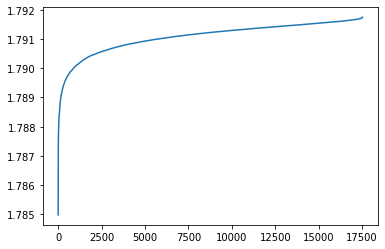

In [46]:
plt.plot(np.sort(PredSoftPeEntropy))

In [13]:
RunModel.weights

[<tf.Variable 'do_gen_vec_4/GenVec:0' shape=(50, 17527) dtype=float32, numpy=
 array([[ 0.16243453,  0.02908837, -0.05304639, ...,  0.0967549 ,
          0.16752236,  0.00122109],
        [ 0.16946778,  0.17687735, -0.24434154, ...,  0.20351033,
          0.01146422, -0.02122133],
        [-0.11813452,  0.06965515, -0.30029345, ..., -0.1768973 ,
         -0.06483164, -0.21791309],
        ...,
        [ 0.08028132, -0.04939915,  0.08795321, ...,  0.17130908,
         -0.04410062, -0.17014025],
        [ 0.07850776,  0.10108462, -0.3984738 , ..., -0.0487695 ,
         -0.0996479 ,  0.03963216],
        [-0.06413594, -0.16045229, -0.20673166, ..., -0.08684859,
         -0.06773606, -0.05707029]], dtype=float32)>,
 <tf.Variable 'do_gen_vec_5/GenVec:0' shape=(50, 2943) dtype=float32, numpy=
 array([[ 0.16243453,  0.29192582,  0.237738  , ...,  0.13544063,
          0.08720778,  0.09771881],
        [-0.00899584, -0.21717721,  0.06196576, ...,  0.2054906 ,
          0.1920995 ,  0.21648271]